## Bayesian linear regression

* Interested in 'Gibbs sampling' for normal linear regression with one independent variable.
* Assume that we have paired data $(y_i, x_i)$
* We want to find the posterior distribution for $\beta_0$ and $\beta_1$ and the variance component $1/ \tau$

### Model

* $y_i \sim \mathcal{N}(\beta_0 + \beta_1x_i, 1/\tau)$
* For the statisticians, this is equivalent to $y_i = \beta_0 + \beta_1x_i + \epsilon$
* The likelihood can be written as $$ \mathcal{L}(\beta_0, \beta_1, \tau \mid X) = \prod_{i=1}^N \mathcal{N}(\beta_0 + \beta_1x_i, 1/\tau)$$
* In Bayesian inference, we choose priors for $\beta_0, \beta_1, \tau$.
* These priors must be conjugate for Gibbs sampling, so for ease we only consider 

$$\beta_0 \sim \mathcal{N}(\mu_0, 1/\tau_0)$$ $$\beta_1 \sim \mathcal{N}(\mu_1, 1/\tau_1)$$ $$\tau \sim \text{Gamma}(\alpha, \beta)$$

## Gibbs sampling

Suppose we have two parameters $\beta_0$ and $\beta_1$ and some data $x$. We want to find the posterior distribution of $p(\beta_0, \beta_1 \mid x)$. Gibbs sampling lets us find the posterior joint distribution if we know the conditional distributions $p(\beta_0 \mid \beta_1, x)$ and $p(\beta_1 \mid \beta_0, x)$ (these are typically easier to find).

### Algorithm

1. Pick initial $\beta_1^{(i)}$
2. Sample $\beta^{(i+1)}_0 \sim p(\beta_0 \mid \beta_1^{(i)}, x)$
3. Sample $\beta_1^{(i+1)} \sim p(\beta_1 \mid \beta_0^{(i+1)}, x)$

We keep repeating to draw more samples. 

* A positive recurrent Markov chain that is both irreducible and aperiodic always has a stationary distribution.

This works, if you want to see how it works read Casella and George (1990)

* The advantage of Gibbs over Metropolis-Hastings is that no tuning is required
* There are more sophisticated packages out there to fit complex models e.g. PyMC3 and Stan

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

In [9]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [10]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [11]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

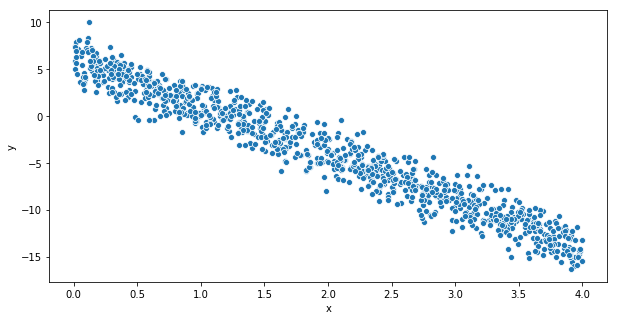

In [12]:
beta_0_true = 6
beta_1_true = -5
tau_true = 0.5

N = 1000
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

ax = sns.scatterplot(x, y)
ax.set(xlabel='x', ylabel='y')
plt.show()

In [33]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": -5,
        "tau": 4}

## specify hyper parameters
hypers = {"mu_0": -6,
         "tau_0": 10,
         "mu_1": 5,
         "tau_1": 10,
         "alpha": 2,
         "beta": 1}

In [34]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

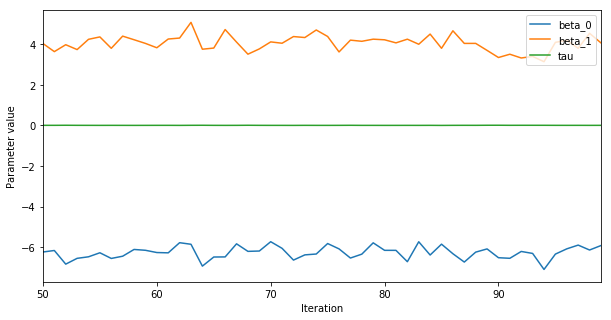

In [35]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)
traceplot = trace[50:100].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
plt.show()

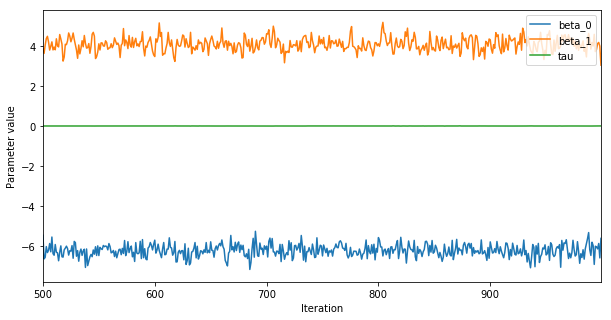

In [36]:
traceplot = trace[500:1000].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
plt.show()

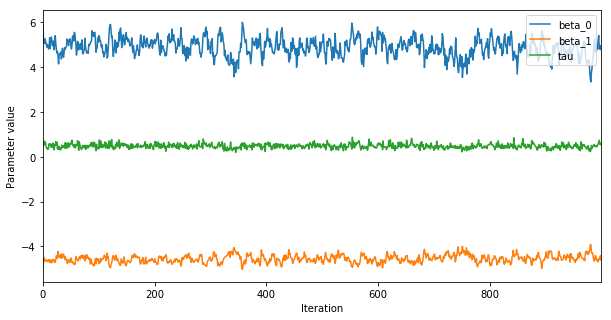

beta_0    4.877811
beta_1   -4.544334
tau       0.477262
dtype: float64

In [22]:
beta_0_true = 6
beta_1_true = -5
tau_true = 0.5

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

iters = 1000
trace = gibbs(y, x, iters, init, hypers)

traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
plt.show()

trace[100:].mean()

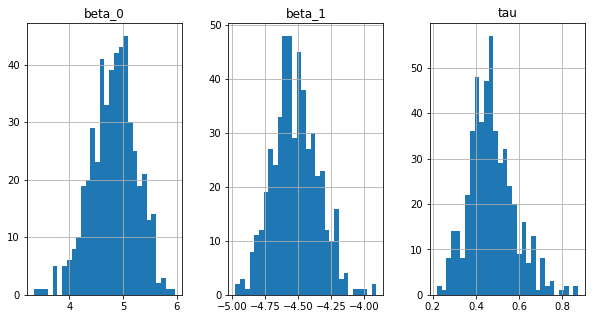

In [23]:
hist_plot = trace[500:1000].hist(bins = 30, layout = (1,3))

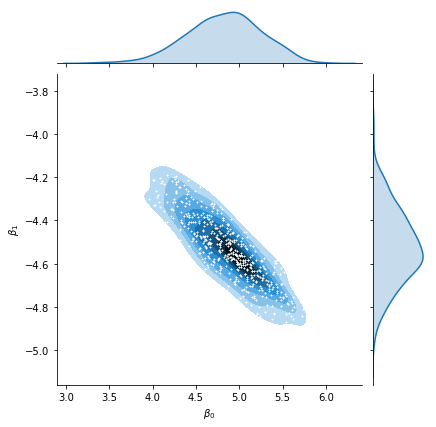

In [27]:
ax = sns.jointplot(x='beta_0', y = 'beta_1', data=trace[500:1000], kind='kde')
ax.plot_joint(plt.scatter, c="w", s=5, linewidth=1, marker="+")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels(r"$\beta_0$", r"$\beta_1$");

Note: If we place a Laplace (double exponential) prior on the $\beta$'s we get the penalised linear regression model with lasso penalty. If we place a Gaussian prior on $\beta$ we get the ridge regression.